In [2]:
import sys
!{sys.executable} -m spacy download en
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)


'C:\Users\Harsh' is not recognized as an internal or external command,
operable program or batch file.
[nltk_data] Downloading package stopwords to C:\Users\Harsh
[nltk_data]     Solanki\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [7]:
#df = pd.read_csv(r'C:\Users\Harsh Solanki\Dropbox\My PC (q-q)\Downloads\Support - Support.csv')

In [7]:
df.head()

,Account Number,Area,Account Name,Blocking Enrollment,Call Source,Category,Cause,Closed Date Time,Created Date Time,Customer Display Name,...,Submit On Behalf Of Email,Submit On Behalf Of NPN,Submit On Behalf Of Writing Number,Third Party Partner,Employees Impacted,TPP Ticket #,Type of enrollment,Active Enrollment,Within 48 hours of Enrollment,Within 24 hours of enrollment
0,NaN,NaN,NaN,NaN,E-mail,Other,SR - Data Update,10/2/2020 8:04 AM,9/8/2020 5:14 AM,Everwell Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,E-mail,Other,None,9/11/2020 8:59 AM,9/8/2020 7:04 AM,Everwell Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,E-mail,Other,SR - Data Update,10/2/2020 8:03 AM,9/8/2020 7:10 AM,Everwell Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,E-mail,Other,SR - Data Update,10/2/2020 8:03 AM,9/8/2020 7:15 AM,Everwell Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,E-mail,Other,SR - Data Update,10/2/2020 8:03 AM,9/8/2020 7:33 AM,Everwell Customer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
df = df[['Description']].copy()
df.head(2)

,Description
0,From: (Toni Eastling) teastling@powerpanels.ne...
1,From: (spamdigest@aflac.com) spamdigest@aflac....


In [120]:
'''

#Cleaning Text - strip HTML
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    return stripped_text
def remove_r(text):
    text = text.replace('\r', '')
    return text
def remove_n(text):
    text = text.replace('\n', '')
    return text
def remove_email(text):
    text = ' '.join([item for item in text.split() if '@' not in item])
    return text
#Removing accented characters
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text
#Expanding Contractions
def expand_contractions(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase
#Removing Special Characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text
#Lemmatizing text
def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text
#Removing Stopwords
# These words are important for our problem. We don't want to remove them.
stopword_list = nltk.corpus.stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('not')

excluding = ['against', 'not', 'don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't",
             'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 
             'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't",
             'needn', "needn't",'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', 
             "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop_words = [word for word in stopword_list]

def remove_stopwords(text, is_lower_case=False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens if token not in excluding]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stop_words]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stop_words]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text
    
'''

<>:1: DeprecationWarning: invalid escape sequence \s
<>:1: DeprecationWarning: invalid escape sequence \s
<ipython-input-120-7cab92e6bebc>:1: DeprecationWarning: invalid escape sequence \s
  '''


'\n\n#Cleaning Text - strip HTML\ndef strip_html_tags(text):\n    soup = BeautifulSoup(text, "html.parser")\n    stripped_text = soup.get_text()\n    return stripped_text\ndef remove_r(text):\n    text = text.replace(\'\r\', \'\')\n    return text\ndef remove_n(text):\n    text = text.replace(\'\n\', \'\')\n    return text\ndef remove_email(text):\n    text = \' \'.join([item for item in text.split() if \'@\' not in item])\n    return text\n#Removing accented characters\ndef remove_accented_chars(text):\n    text = unicodedata.normalize(\'NFKD\', text).encode(\'ascii\', \'ignore\').decode(\'utf-8\', \'ignore\')\n    return text\n#Expanding Contractions\ndef expand_contractions(phrase):\n    # specific\n    phrase = re.sub(r"won\'t", "will not", phrase)\n    phrase = re.sub(r"can\'t", "can not", phrase)\n    # general\n    phrase = re.sub(r"n\'t", " not", phrase)\n    phrase = re.sub(r"\'re", " are", phrase)\n    phrase = re.sub(r"\'s", " is", phrase)\n    phrase = re.sub(r"\'d", " woul

In [121]:
'''
def normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,
                     accented_char_removal=True, text_lower_case=False, 
                     text_lemmatization=True, special_char_removal=True, 
                     stopword_removal=True, remove_r_f=True, remove_n_f=True, remove_emails=True):
    
    normalized_corpus = []
    
    # normalize each document in the corpus
    for doc in corpus:
        # strip HTML
        if html_stripping:
            doc = strip_html_tags(doc)
        if remove_r_f:
            doc = remove_r(doc)
        if remove_n_f:
            doc = remove_n(doc)
        if remove_emails:
            doc = remove_email(doc)
        # remove accented characters
        if accented_char_removal:
            doc = remove_accented_chars(doc)
        # expand contractions    
        if contraction_expansion:
            doc = expand_contractions(doc)
        # lowercase the text    
        if text_lower_case:
            doc = doc.lower()
        # remove extra newlines
        doc = re.sub(r'[\r|\n|\r\n]+', ' ',doc)
        doc = re.sub('\S*@\S*\s?', '', doc)  # remove emails
        doc = re.sub('\s+', ' ', doc)  # remove newline chars
        doc = re.sub("\'", "", doc)  # remove single quotes

        #remove rn which comes from \r and \n after stripping spaces and slash (\)
        doc = doc.replace('rn', '')
        # insert spaces between special characters to isolate them    
        special_char_pattern = re.compile(r'([{.(-)!}])')
        doc = special_char_pattern.sub(" \\1 ", doc)
        # lemmatize text
        if text_lemmatization:
            doc = lemmatize_text(doc)
        # remove special characters    
        if special_char_removal:
            doc = remove_special_characters(doc)  
        # remove extra whitespace
        doc = re.sub(' +', ' ', doc)
        # Remove leading/trailing whitespace
        doc = re.sub('\s+', ' ', doc)
        # Removing numbers
        #doc = re.sub(r"\d+","",doc)
        # Remove URLs
        doc = re.sub(r'http\S+', '', doc) 
        # Remove extra space and tabs
        doc = re.sub('\s+', ' ', doc) 
        # Reove accronyms
        #doc = re.sub(r"\b[A-Z]{2,}\b", "", doc)
        # remove stopwords
        if stopword_removal:
            doc = remove_stopwords(doc, is_lower_case=text_lower_case)
        normalized_corpus.append(doc)
        
    return normalized_corpus
    
    '''

<>:1: DeprecationWarning: invalid escape sequence \S
<>:1: DeprecationWarning: invalid escape sequence \S
<ipython-input-121-ad982b3a215a>:1: DeprecationWarning: invalid escape sequence \S
  '''


'\ndef normalize_corpus(corpus, html_stripping=True, contraction_expansion=True,\n                     accented_char_removal=True, text_lower_case=False, \n                     text_lemmatization=True, special_char_removal=True, \n                     stopword_removal=True, remove_r_f=True, remove_n_f=True, remove_emails=True):\n    \n    normalized_corpus = []\n    \n    # normalize each document in the corpus\n    for doc in corpus:\n        # strip HTML\n        if html_stripping:\n            doc = strip_html_tags(doc)\n        if remove_r_f:\n            doc = remove_r(doc)\n        if remove_n_f:\n            doc = remove_n(doc)\n        if remove_emails:\n            doc = remove_email(doc)\n        # remove accented characters\n        if accented_char_removal:\n            doc = remove_accented_chars(doc)\n        # expand contractions    \n        if contraction_expansion:\n            doc = expand_contractions(doc)\n        # lowercase the text    \n        if text_lower_cas

In [122]:
'''
print("Pre-processing the description field with use of Lemmatization")
df["Description_cleaned"] = normalize_corpus(df["Description"].tolist())
'''

'\nprint("Pre-processing the description field with use of Lemmatization")\ndf["Description_cleaned"] = normalize_corpus(df["Description"].tolist())\n'

In [6]:
#import pickle
# open a file, where you stored the pickled data
#file = open(r'C:\Users\Harsh Solanki\Downloads\blabla\blabla_cleaned_new.pkl', 'rb')

# dump information to that file
#df_cleaned = pickle.load(file)

# close the file
#file.close()

In [5]:
#df_cleaned = df_cleaned[['Description','Description_cleaned']].copy()
#df_cleaned.head(2)

In [4]:
#print(df_cleaned["Description"][650])
#print('--'*10)
#print(df_cleaned["Description_cleaned"][650])

In [19]:
def normalize_corpus_rn(corpus):
    
    normalized_corpus_rn = []
    
    # normalize each document in the corpus
    for doc in corpus:
        doc = doc.replace('rn', '')
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        # Reove accronyms
        doc = re.sub(r"\b[A-Z]{2,}\b", "", doc)
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        normalized_corpus_rn.append(doc)
        
    return normalized_corpus_rn

In [20]:
print("Pre-processing the description field with use of Lemmatization")
df_cleaned["Description_cleaned_new"] = normalize_corpus_rn(df_cleaned["Description_cleaned"].tolist())

Pre-processing the description field with use of Lemmatization


In [21]:
df_cleaned.head(2)

,Description,Description_cleaned,Description_cleaned_new
0,From: (Toni Eastling) teastling@powerpanels.ne...,Toni Eastling Everwell Support 982020 51417 am...,Toni Eastling Everwell Support amsubject Ext...
1,From: (spamdigest@aflac.com) spamdigest@aflac....,TPI INCIDENTS 982020 70406 AMrnSubject End Use...,AMSubject End User Digest New Messages En...


In [3]:
#df_cleaned.to_pickle(r'C:\Users\Harsh Solanki\Downloads\blabla\blabla_cleaned_newest.pkl')

In [2]:
#print(df_cleaned["Description"][650])
#print('--'*10)
#print(df_cleaned["Description_cleaned"][650])
#print('--'*10)
#print(df_cleaned["Description_cleaned_new"][650])

# Tokenize Sentences and Clean

In [26]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) # deacc=True (Removed punctuation)
        yield(sent)  

# Convert to list
data = df_cleaned.Description_cleaned_new.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])

[['toni', 'eastling', 'everwell', 'support', 'amsubject', 'exteal', 'everwell', 'open', 'enrollment', 'startedas', 'please', 'forward', 'future', 'inquiry', 'request', 'ish', 'ramirez', 'need', 'immediate', 'assistance', 'please', 'call', 'power', 'panels', 'office', 'caution', 'email', 'originate', 'outside', 'aflac', 'click', 'link', 'open', 'attachment', 'unless', 'recognize', 'sender', 'know', 'content', 'safe']]


In [38]:
#!pip3 install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-2.2.0/en_core_web_sm-2.2.0.tar.gz

  Created wheel for en-core-web-sm: filename=en_core_web_sm-2.2.0-py3-none-any.whl size=12019125 sha256=1a87744ebae370186578ee504124c938abdd40f5556da7f2be390f48e154c7a3
  Stored in directory: c:\users\harsh solanki\appdata\local\pip\cache\wheels\fc\31\e9\092e6f05b2817c9cb45804a3d1bf2b9bf6575742c01819337c
Successfully built en-core-web-sm


In [39]:
#!pip install "nltk==3.4.5"

  Created wheel for nltk: filename=nltk-3.4.5-py3-none-any.whl size=1449909 sha256=9d649ef4383f00bb905326234d1891e041fe1df7b67c871d49ef7e10cc4b4fdd
  Stored in directory: c:\users\harsh solanki\appdata\local\pip\cache\wheels\23\18\48\8fd6ec11da38406b309470566d6f099c04805d2ec61d7829e7
Successfully built nltk
  Attempting uninstall: nltk
    Found existing installation: nltk 3.5
    Uninstalling nltk-3.5:
      Successfully uninstalled nltk-3.5


# Build the Bigram, Trigram Models and Lemmatize

lemmatizing each word to its root form, keeping only nouns, adjectives, verbs and adverbs because these POS tags are the ones usually contributing the most to the meaning of the sentences. 

In [42]:
import en_core_web_sm
nlp = en_core_web_sm.load()

In [43]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en-core-web-sm-2.2.0', disable=['parser', 'ner'])
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

# Build the Topic Model

- Will need the corpus and the dictionary.  

- The trained topics (keywords and weights) are printed below as well.

In [45]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.065*"send" + 0.040*"issue" + 0.033*"support" + 0.030*"enrollment" + '
  '0.027*"call" + 0.022*"ticket" + 0.018*"team" + 0.017*"moe" + '
  '0.017*"provide" + 0.017*"navigator"'),
 (1,
  '0.103*"email" + 0.050*"link" + 0.050*"open" + 0.049*"content" + '
  '0.043*"recognize" + 0.041*"safe" + 0.039*"originate" + 0.039*"attachment" + '
  '0.034*"sender" + 0.031*"name"'),
 (2,
  '0.090*"message" + 0.066*"information" + 0.060*"error" + 0.045*"mail" + '
  '0.040*"attachment" + 0.037*"receive" + 0.026*"notify" + 0.026*"employee" + '
  '0.026*"sender" + 0.023*"contain"'),
 (3,
  '0.051*"agent" + 0.021*"product" + 0.021*"review" + 0.019*"add" + '
  '0.018*"employee" + 0.018*"able" + 0.018*"plan" + 0.018*"show" + '
  '0.018*"option" + 0.014*"update"')]


In [48]:
from gensim.test.utils import datapath
# Save model to disk.
temp_file = datapath("lda_model")
lda_model.save(temp_file)

In [49]:
# Load a potentially pretrained model from disk.
lda_model = lda_model.load(temp_file)

# What is the Dominant topic and its percentage contribution in each document

In LDA models, each document is composed of multiple topics. But, typically only one of the topics is dominant. The below code extracts this dominant topic for each sentence and shows the weight of the topic and the keywords in a nicely formatted output.

This way, we will know which document belongs predominantly to which topic.

In [50]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.6220,"email, link, open, content, recognize, safe, o...","[eastle, open, enrollment, starteda, please, f..."
1,1,0.0,0.3907,"send, issue, support, enrollment, call, ticket...","[amsubject, new, message, new, message, messag..."
2,2,1.0,0.9681,"email, link, open, content, recognize, safe, o...","[action, sure, reset, password, privacy, polic..."
3,3,1.0,0.9682,"email, link, open, content, recognize, safe, o...","[account, password, sure, reset, password, pri..."
4,4,1.0,0.4082,"email, link, open, content, recognize, safe, o...","[open, enrollment, remain, still, enrollsent, ..."
5,5,1.0,0.9752,"email, link, open, content, recognize, safe, o...","[benefit, enrollment, enrollment, experience, ..."
6,6,3.0,0.3440,"agent, product, review, add, employee, able, p...","[ewiunable, send, already, exist, log, record,..."
7,7,3.0,0.8245,"agent, product, review, add, employee, able, p...","[write, log, system, keep, spin, time, still, ..."
8,8,3.0,0.7085,"agent, product, review, add, employee, able, p...","[agent, site, keep, spin, allow]"
9,9,3.0,0.8239,"agent, product, review, add, employee, able, p...","[agent, wife, invitation, acct, invitation, cl..."


In [98]:
#df_dominant_topic.to_csv(r'C:\Users\Harsh Solanki\Downloads\blabla\topics_assigned.csv')

# The most representative sentence for each topic (not that useful for our use case) (IGNORE)
To get samples of sentences that most represent a given topic. This code gets the most suitable sentence for each topic.

In [51]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(4)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9656,"send, issue, support, enrollment, call, ticket, team, moe, provide, navigator","[pmsubject, phone, number, direct, call, request, call, tomorrow, pm, send, phone, number, direc..."
1,1.0,0.9792,"email, link, open, content, recognize, safe, originate, attachment, sender, name","[benefit, enrollment, completeplease, name, email, address, long, benefit, enrollment, experienc..."
2,2.0,0.9643,"message, information, error, mail, attachment, receive, notify, employee, sender, contain","[send, carver, confidential, information, intend, solely, addressee_read, message, mail, attachm..."
3,3.0,0.9848,"agent, product, review, add, employee, able, plan, show, option, update","[write, application, alexxa, torre, whole, term, std, rider, choose, add, cart, however, click, ..."


# Frequency Distribution of Word Counts in Documents
Plotting the document word counts distribution.

In [1]:
#df_dominant_topic.head(2)

In [52]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

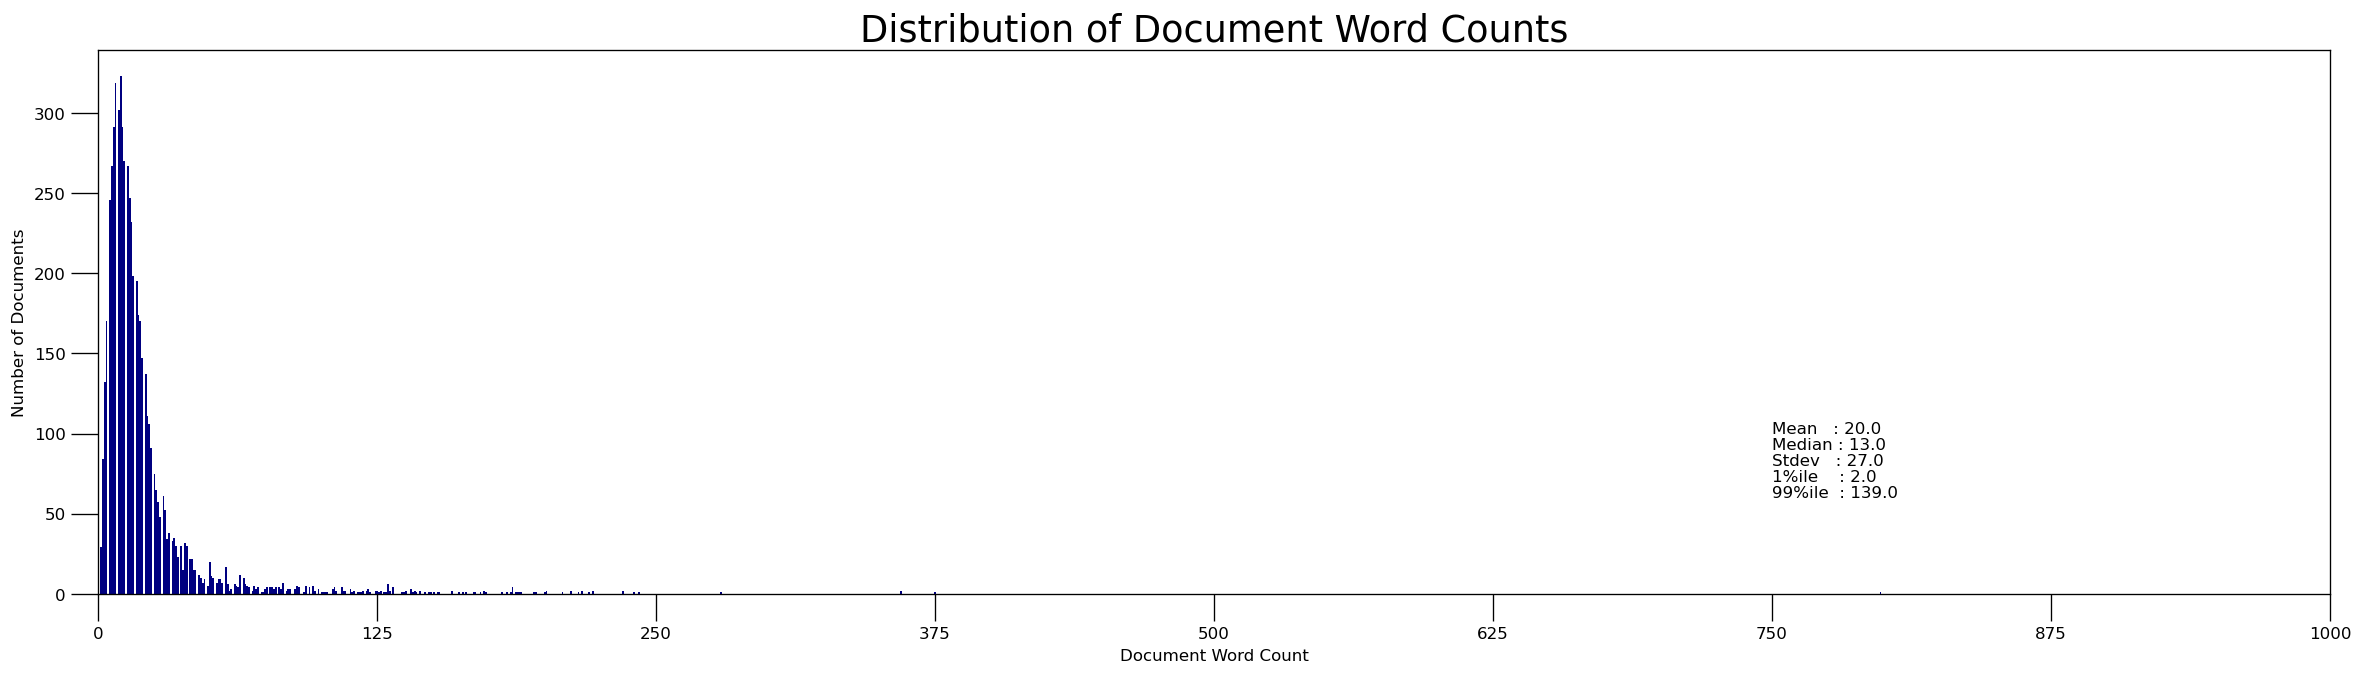

In [106]:
# Plot
plt.figure(figsize=(24,6), dpi=120)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

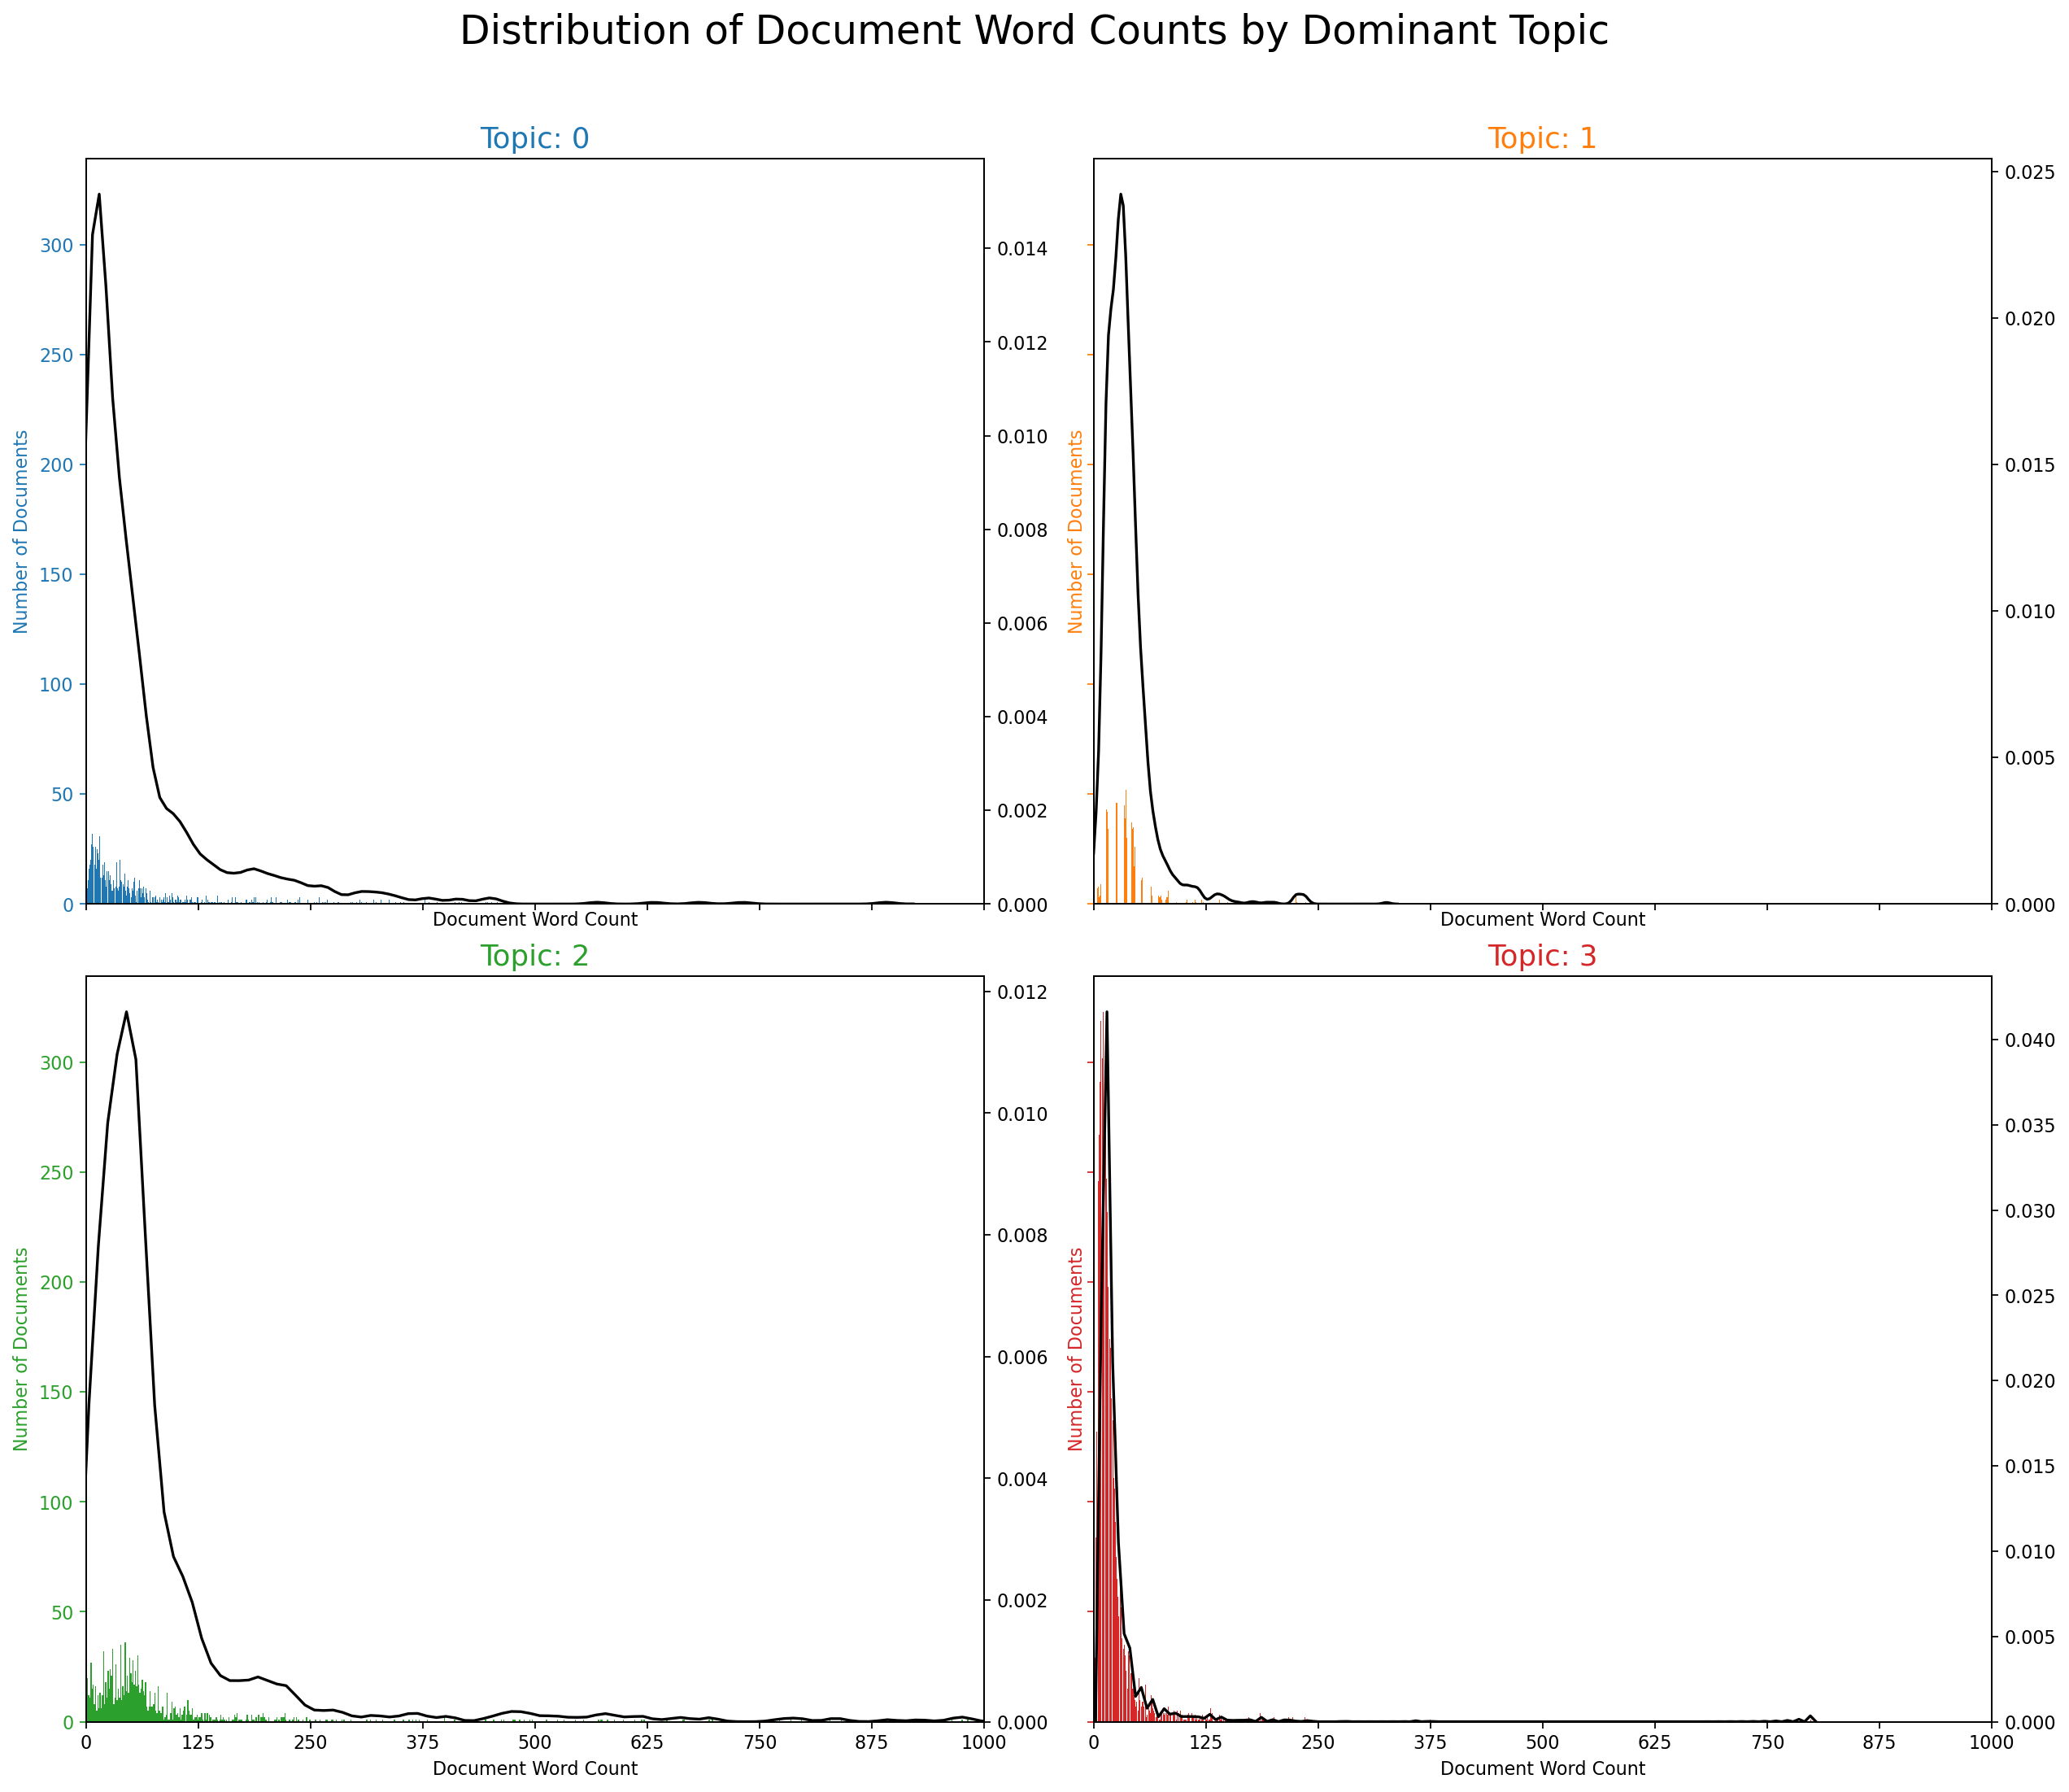

In [54]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

In [56]:
!pip install wordcloud

# Word Clouds of Top N Keywords in Each Topic

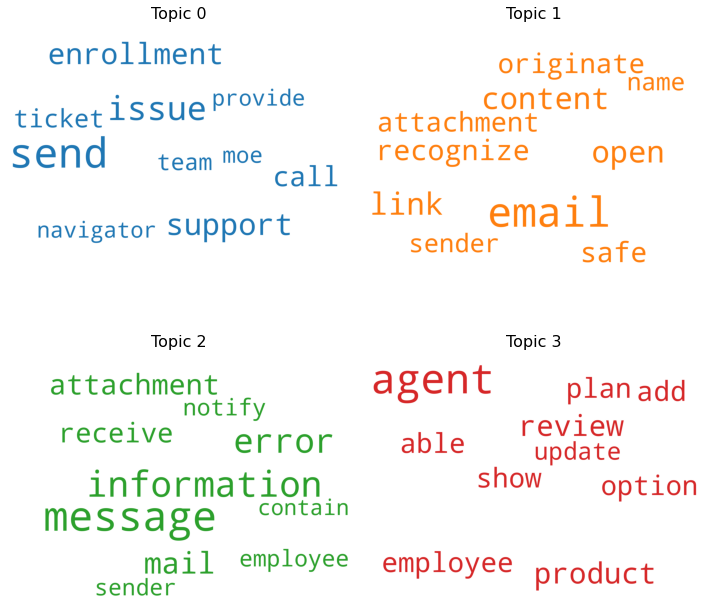

In [109]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Word Counts of Topic Keywords

Plotting the word counts and the weights of each keyword in the same chart. This helps us to keep an eye out on the words that occur in multiple topics and the ones whose relative frequency is more than the weight. Often such words turn out to be less important. The chart I’ve drawn below is a result of adding several such words to the stop words list in the beginning and re-running the training process.

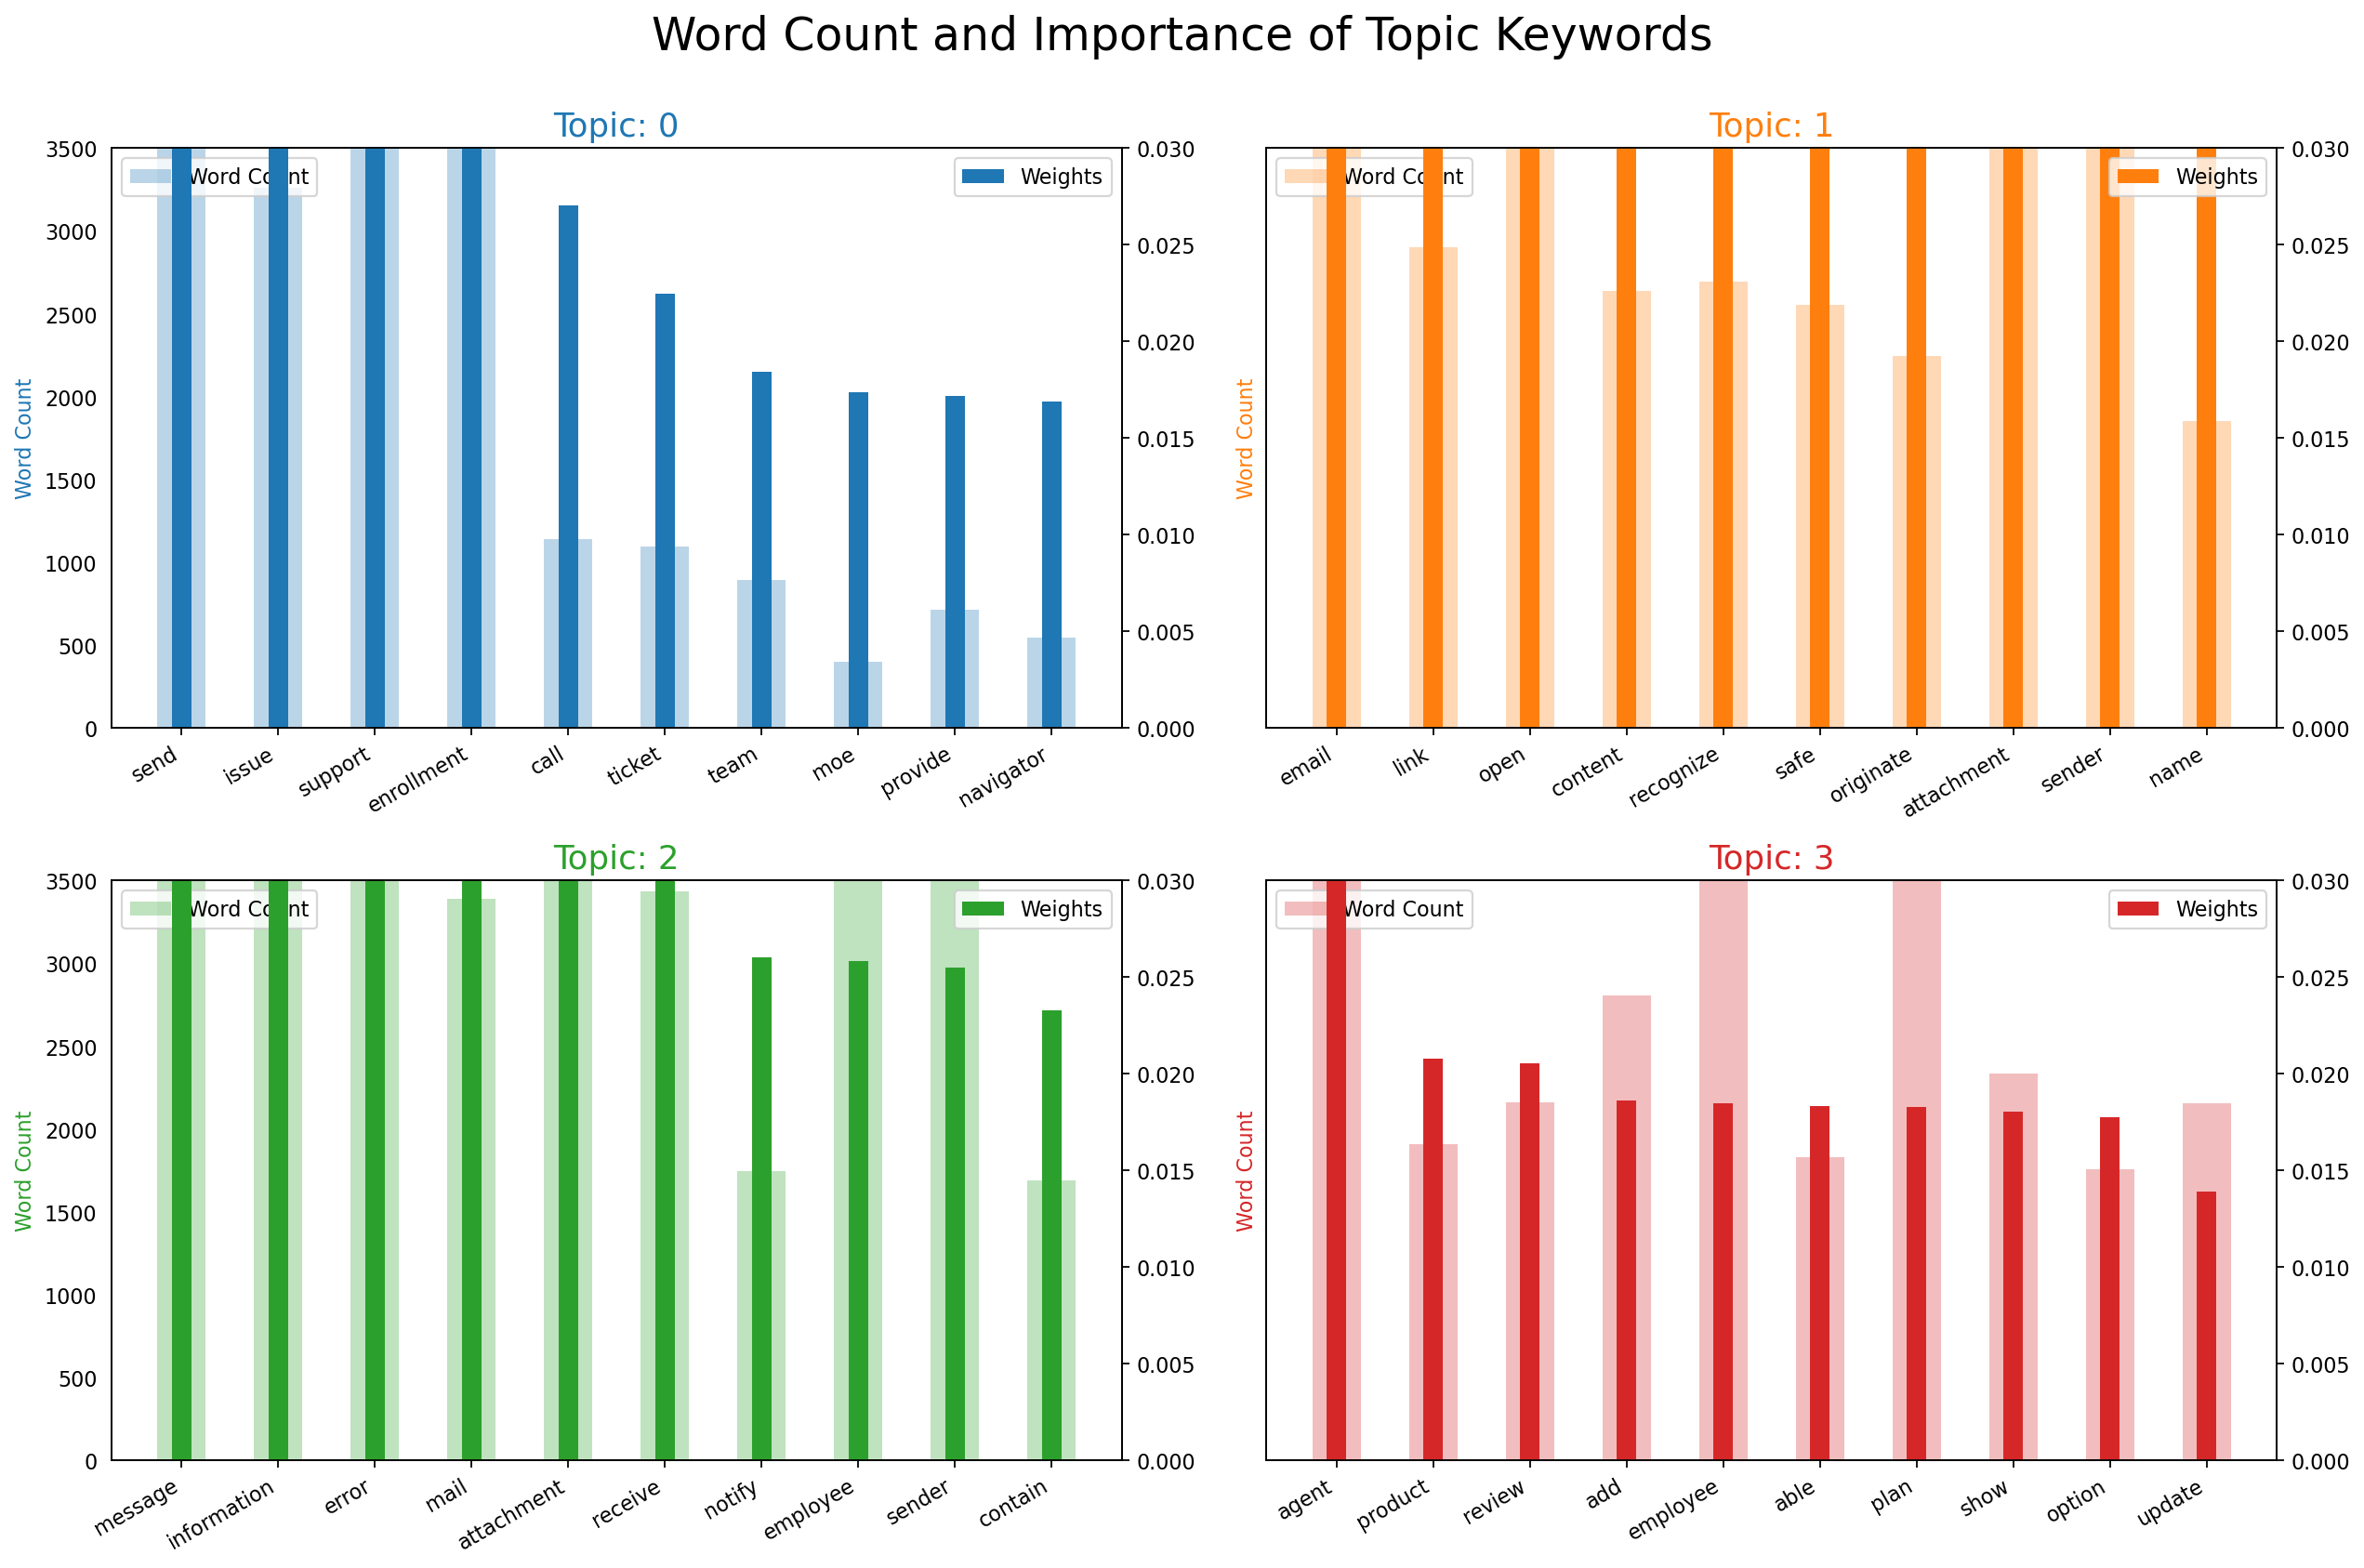

In [58]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

# Sentence Chart Colored by Topic

Each word in the document is representative of one of the 4 topics. Let’s color each word in the given documents by the topic id it is attributed to. The color of the enclosing rectangle is the topic assigned to the document.


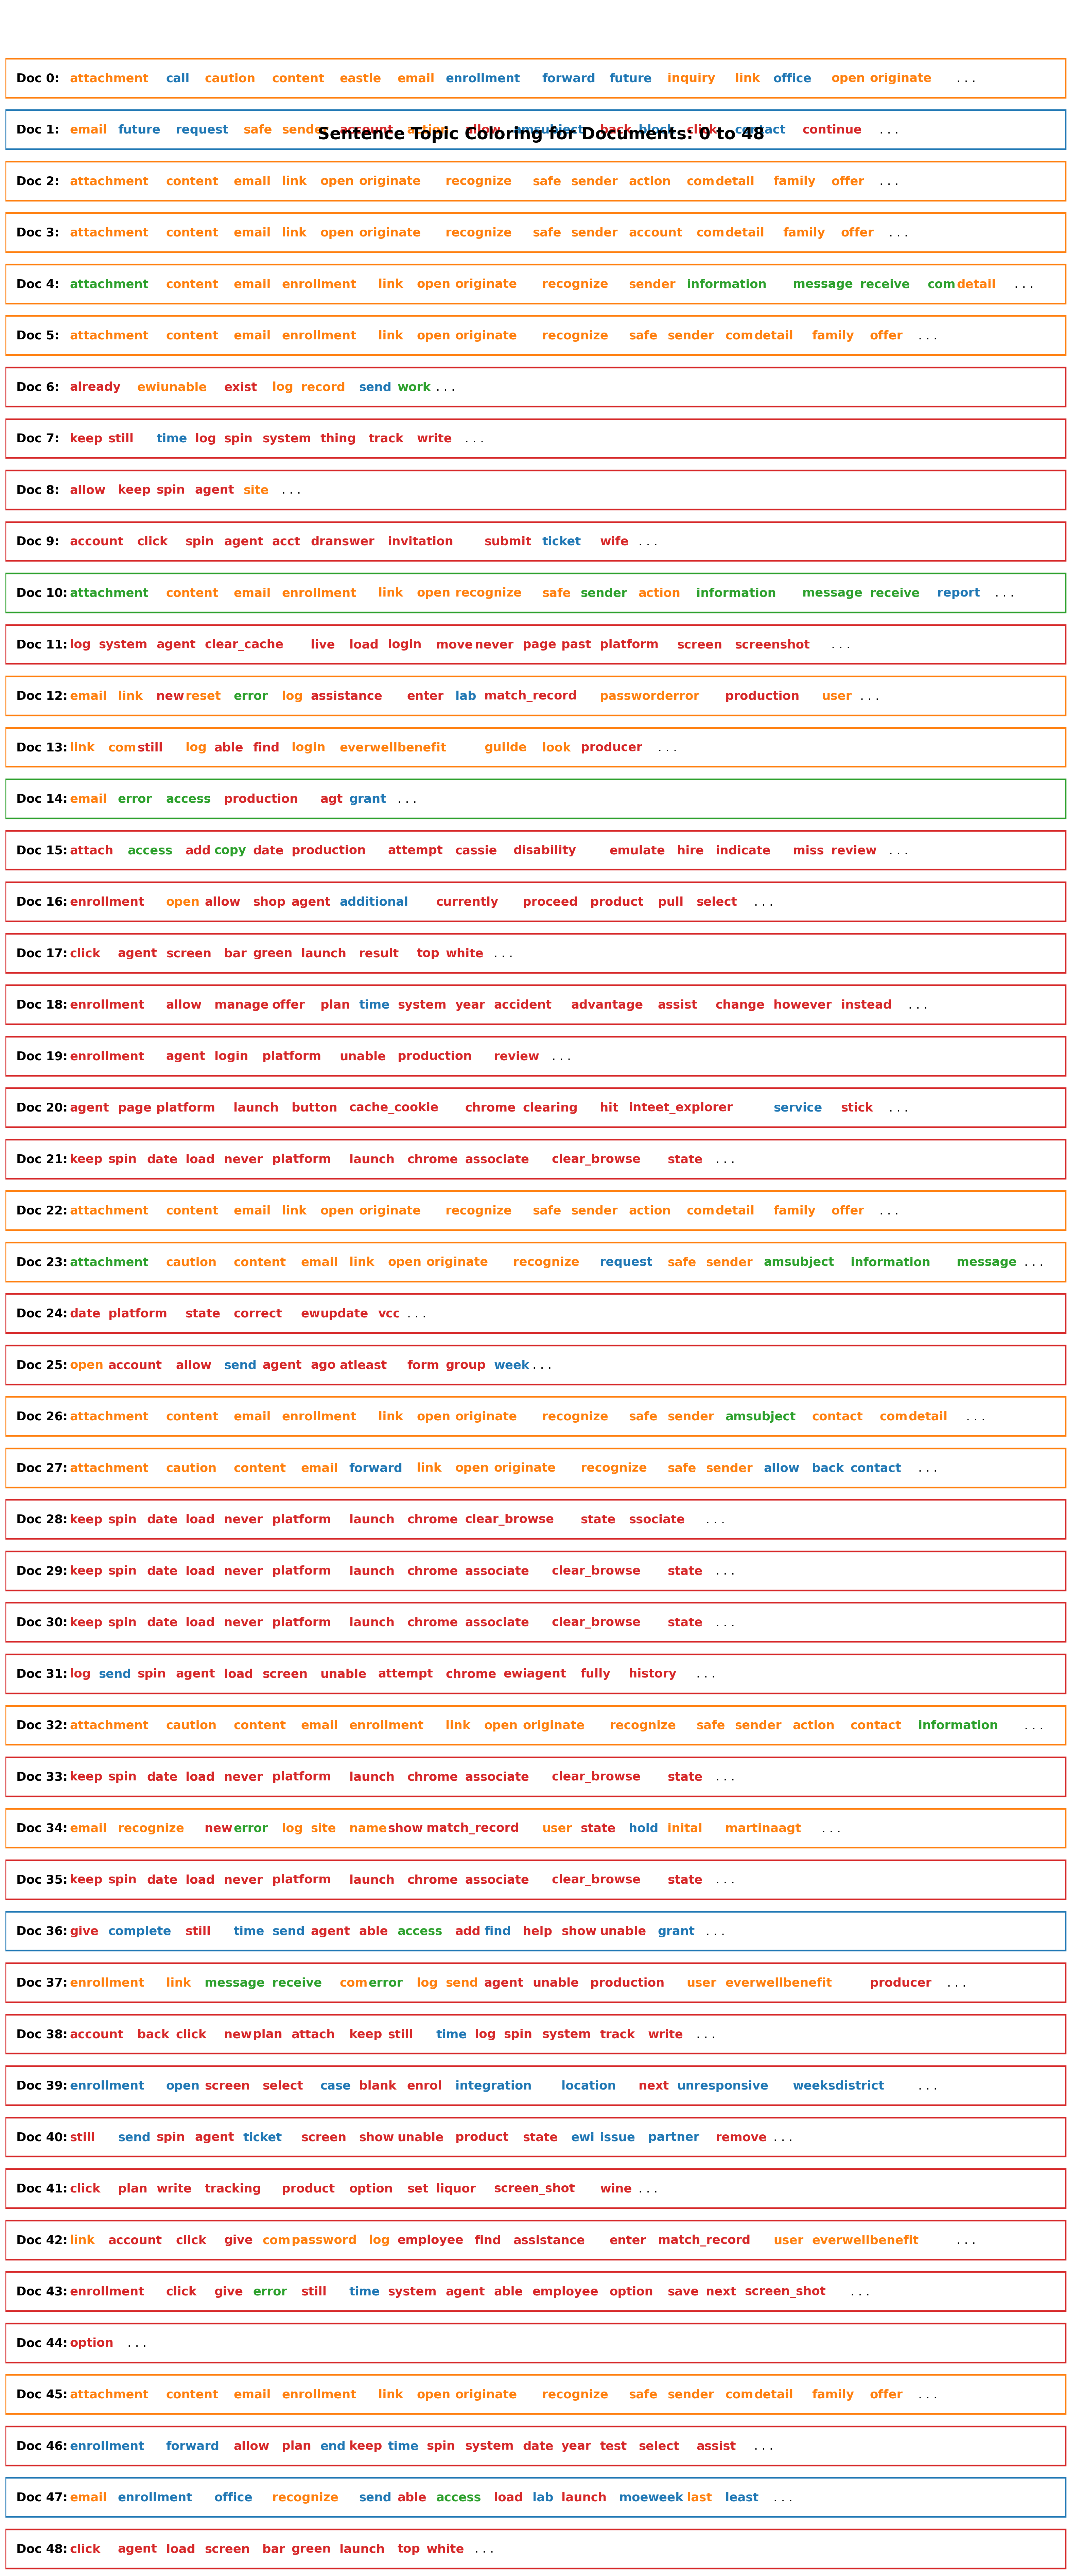

In [110]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 50):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

# What are the most discussed topics in the documents?
Let’s compute the total number of documents attributed to each topic.



In [60]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [111]:
df_dominant_topic_in_each_doc.head()

,Dominant_Topic,count
0,0,1078
1,1,1783
2,2,1301
3,3,5942


Let’s make two plots:

- The number of documents for each topic by assigning the document to the topic that has the most weight in that document.
- The number of documents for each topic by by summing up the actual weight contribution of each topic to respective documents.

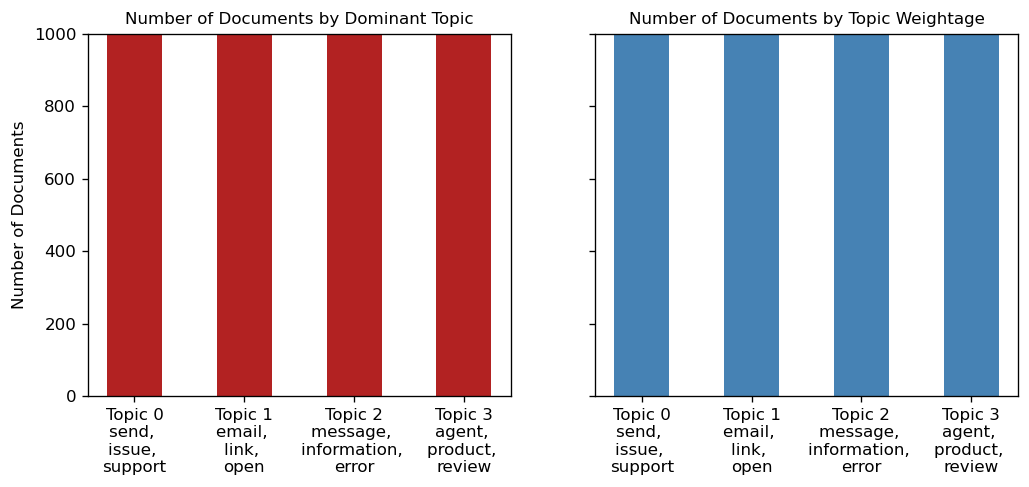

In [61]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

#  t-SNE Clustering Chart

Let’s visualize the clusters of documents in a 2D space using t-SNE (t-distributed stochastic neighbor embedding) algorithm.

In [62]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9865 samples in 0.040s...
[t-SNE] Computed neighbors for 9865 samples in 0.599s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9865
[t-SNE] Computed conditional probabilities for sample 2000 / 9865
[t-SNE] Computed conditional probabilities for sample 3000 / 9865
[t-SNE] Computed conditional probabilities for sample 4000 / 9865
[t-SNE] Computed conditional probabilities for sample 5000 / 9865
[t-SNE] Computed conditional probabilities for sample 6000 / 9865
[t-SNE] Computed conditional probabilities for sample 7000 / 9865
[t-SNE] Computed conditional probabilities for sample 8000 / 9865
[t-SNE] Computed conditional probabilities for sample 9000 / 9865
[t-SNE] Computed conditional probabilities for sample 9865 / 9865
[t-SNE] Mean sigma: 0.000512
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.922318
[t-SNE] KL divergence after 1000 iterations: 0.857119


Loading BokehJS ...

# pyLDAVis

In [63]:
!pip install pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97716 sha256=111091af66b2447ac96b5f83ebccfabf1dd3458f99c3c58548c55852c368f0d4
  Stored in directory: c:\users\harsh solanki\appdata\local\pip\cache\wheels\31\8c\a0\24a443892f2134e691d59c8c6c35e19821e02f85e49871f8fd
Successfully built pyLDAvis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.359008 -0.001030       1        1  33.934898
2     -0.130501 -0.274235       2        1  24.849386
0     -0.126146  0.304452       3        1  22.245712
1     -0.102361 -0.029186       4        1  18.970003, topic_info=            Term         Freq        Total Category  logprob  loglift
37       message  7911.000000  7911.000000  Default  30.0000  30.0000
5          email  7944.000000  7944.000000  Default  29.0000  29.0000
35   information  5821.000000  5821.000000  Default  28.0000  28.0000
74         error  5259.000000  5259.000000  Default  27.0000  27.0000
113        agent  6122.000000  6122.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
124      address   433.415161   928.100464   Topic4  -5.0476   0.9009
106         send   604.642517  6098.160156   Topic4  -4.7146  -0.6488
57        policy   453.789124  2045.367676   Topic4  -5.0016   0.1566
184         look   372.759430   568.045349   Topic4  -5.1983   1.2410
29       contact   372.139557  1396.131104   Topic4  -5.2000   0.3401

[222 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
121       1  0.963362      able
121       2  0.036550      able
122       2  0.998486    access
210       1  0.999416  accident
22        1  0.807167   account
...     ...       ...       ...
112       1  0.987297     write
112       2  0.012295     write
1203      4  0.998033       www
160       1  0.998401      year
160       4  0.000767      year

[256 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 1, 2])

In [124]:
import pickle
# open a file, where you stored the pickled data
file = open(r'C:\Users\Harsh Solanki\Downloads\aflac\aflac_cleaned_new.pkl', 'rb')

# dump information to that file
df_experimenting = pickle.load(file)

# close the file
file.close()

In [125]:
def normalize_corpus_rn(corpus):
    
    normalized_corpus_rn = []
    
    # normalize each document in the corpus
    for doc in corpus:
        doc = doc.replace('rn', '')
        # Removing numbers
        doc = re.sub(r"\d+","",doc)
        normalized_corpus_rn.append(doc)
        
    return normalized_corpus_rn

In [126]:
print("Pre-processing the description field with use of Lemmatization")
df_experimenting["Description_cleaned_new"] = normalize_corpus_rn(df_cleaned["Description_cleaned"].tolist())

Pre-processing the description field with use of Lemmatization


In [128]:
from sklearn.feature_extraction.text import TfidfVectorizer
tickets = [ticket for ticket in df_experimenting.Description_cleaned_new]
# get tf-idf features 
ptvf = TfidfVectorizer(use_idf=True, min_df=0.05, max_df=0.95, ngram_range=(1,1), sublinear_tf=True)
ptvf_features = ptvf.fit_transform(tickets)
# view feature set dimensions
print(ptvf_features.shape)

(10105, 229)


In [127]:
import numpy as np


# prints components of all the topics 
# obtained from topic modeling
def print_topics_udf(topics, total_topics=1,
                     weight_threshold=0.0001,
                     display_weights=True,
                     num_terms=None):
    
    for index in range(total_topics):
        topic = topics[index]
        topic = [(term, float(wt))
                 for term, wt in topic]
        topic = [(word, round(wt,2)) 
                 for word, wt in topic 
                 if abs(wt) >= weight_threshold]
                     
        if display_weights:
            print('Topic #'+str(index+1)+' with weights')
            print(topic[:num_terms]) if num_terms else topic
        else:
            print('Topic #'+str(index+1)+' without weights')
            tw = [term for term, wt in topic]
            print(tw[:num_terms]) if num_terms else tw
        print()
        

# extracts topics with their terms and weights
# format is Topic N: [(term1, weight1), ..., (termn, weightn)]        
def get_topics_terms_weights(weights, feature_names):
    feature_names = np.array(feature_names)
    sorted_indices = np.array([list(row[::-1]) 
                           for row 
                           in np.argsort(np.abs(weights))])
    sorted_weights = np.array([list(wt[index]) 
                               for wt, index 
                               in zip(weights,sorted_indices)])
    sorted_terms = np.array([list(feature_names[row]) 
                             for row 
                             in sorted_indices])
    
    topics = [np.vstack((terms.T, 
                     term_weights.T)).T 
              for terms, term_weights 
              in zip(sorted_terms, sorted_weights)]     
    
    return topics         

In [129]:
import pyLDAvis
import pyLDAvis.sklearn
from sklearn.decomposition import NMF

pyLDAvis.enable_notebook()
total_topics = 4

In [130]:
# build topic model on positive sentiment review features
nmf = NMF(n_components=total_topics, 
          random_state=42, alpha=0.1, l1_ratio=0.5)
nmf.fit(ptvf_features)      
# extract features and component weights
feature_names = ptvf.get_feature_names()
weights = nmf.components_
# extract and display topics and their components
topics = get_topics_terms_weights(weights, feature_names)
save_topics = print_topics_udf(topics=topics,
                 total_topics=total_topics,
                 num_terms=20,
                 display_weights=True)

Topic #1 with weights
[('message', 1.9), ('fortune', 1.88), ('mail', 1.66), ('everwell', 1.5), ('company', 1.44), ('use', 1.35), ('aflac', 1.34), ('information', 1.31), ('may', 1.22), ('support', 1.22), ('fax', 1.19), ('work', 1.16), ('receive', 1.16), ('good', 1.12), ('confidential', 1.1), ('intend', 1.09), ('com', 1.07), ('error', 1.07), ('contain', 1.06), ('notify', 1.06)]

Topic #2 with weights
[('agent', 3.88), ('try', 2.63), ('ee', 2.33), ('review', 2.2), ('please', 2.19), ('add', 1.99), ('show', 1.91), ('get', 1.69), ('enroll', 1.68), ('option', 1.63), ('plan', 1.49), ('see', 1.43), ('thank', 1.39), ('able', 1.37), ('enrollment', 1.35), ('state', 1.29), ('app', 1.27), ('screen', 1.23), ('account', 1.23), ('error', 1.21)]

Topic #3 with weights
[('american', 1.75), ('assurance', 1.71), ('family', 1.69), ('columbus', 1.66), ('life', 1.61), ('policy', 1.49), ('company', 1.47), ('aflac', 1.42), ('benefit', 1.22), ('com', 1.2), ('summary', 1.1), ('everwell', 1.06), ('mean', 1.04), ('

C:\Users\Harsh Solanki\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1076: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [133]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['toni', 'eastling', 'everwell', 'support', 'amsubject', 'exteal', 'everwell', 'open', 'enrollment', 'startedas', 'please', 'forward', 'future', 'inquiry', 'request', 'ish', 'ramirez', 'need', 'immediate_assistance', 'please', 'call', 'power', 'panels', 'office', 'caution', 'email', 'originate', 'outside', 'aflac', 'click', 'link', 'open', 'attachment', 'unless', 'recognize', 'sender', 'know', 'content', 'safe']


In [134]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [136]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['eastle', 'open', 'enrollment', 'starteda', 'please', 'forward', 'future', 'inquiry', 'request', 'immediate_assistance', 'call', 'power', 'panel', 'office', 'caution', 'email', 'originate', 'link', 'open', 'attachment', 'recognize', 'sender', 'content', 'safe']]


In [137]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 2), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1)]]


In [138]:
id2word[0]

'attachment'

In [139]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('attachment', 1),
  ('call', 1),
  ('caution', 1),
  ('content', 1),
  ('eastle', 1),
  ('email', 1),
  ('enrollment', 1),
  ('forward', 1),
  ('future', 1),
  ('immediate_assistance', 1),
  ('inquiry', 1),
  ('link', 1),
  ('office', 1),
  ('open', 2),
  ('originate', 1),
  ('panel', 1),
  ('please', 1),
  ('power', 1),
  ('recognize', 1),
  ('request', 1),
  ('safe', 1),
  ('sender', 1),
  ('starteda', 1)]]

In [140]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [141]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.175*"message" + 0.107*"information" + 0.085*"mail" + 0.068*"attachment" + '
  '0.061*"receive" + 0.054*"notify" + 0.049*"sender" + 0.049*"copy" + '
  '0.047*"intend" + 0.043*"error"'),
 (1,
  '0.222*"assistance" + 0.139*"log" + 0.127*"enter" + 0.117*"password" + '
  '0.066*"reset" + 0.065*"user" + 0.038*"result" + 0.016*"everwellbenefit" + '
  '0.015*"launch" + 0.013*"top"'),
 (2,
  '0.271*"shop" + 0.157*"office" + 0.120*"dependent" + 0.097*"fax" + '
  '0.093*"minute" + 0.060*"split" + 0.000*"jolynne_mack" + 0.000*"navigator" + '
  '0.000*"provide" + 0.000*"sale"'),
 (3,
  '0.346*"system" + 0.216*"correct" + 0.177*"info" + 0.092*"spin" + '
  '0.027*"verify" + 0.012*"ew" + 0.010*"nothing_happen" + 0.008*"ee" + '
  '0.004*"vcc" + 0.002*"need"'),
 (4,
  '0.761*"employee" + 0.071*"save" + 0.037*"track" + 0.033*"duplicate" + '
  '0.014*"button" + 0.009*"site" + 0.008*"auto" + 0.008*"accept" + '
  '0.002*"validate" + 0.000*"navigator"'),
 (5,
  '0.284*"error" + 0.164*"update" + 0.1

In [142]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -12.25964386459786

Coherence Score:  0.405515507107929


In [143]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
14    -0.163632 -0.261262       1        1  19.283737
0     -0.235279  0.296330       2        1  13.208050
11    -0.123379 -0.074888       3        1  11.957557
9     -0.237685  0.061890       4        1  11.020297
10    -0.058957 -0.149018       5        1   5.830213
19    -0.127606  0.193823       6        1   5.454901
7     -0.087431 -0.168166       7        1   4.792329
13    -0.057803 -0.151028       8        1   4.644396
5     -0.018502  0.094579       9        1   3.559653
15     0.021948 -0.036039      10        1   3.544990
8      0.024278 -0.038545      11        1   3.216360
4      0.078093  0.023945      12        1   2.461460
6     -0.012101 -0.103767      13        1   2.291686
16    -0.044966  0.133358      14        1   1.893206
3      0.142080  0.031144      15        1   1.577161
12     0.174493  0.046385      16        1   1.262237
1      0.174597  0.032765      17        1   1.246347
17     0.194019  0.033937      18        1   0.976356
18     0.168998  0.002364      19        1   0.939995
2      0.188836  0.032191      20        1   0.839066, topic_info=            Term         Freq        Total Category  logprob  loglift
152     employee  7401.000000  7401.000000  Default  30.0000  30.0000
131        agent  6661.000000  6661.000000  Default  29.0000  29.0000
44       message  9375.000000  9375.000000  Default  28.0000  28.0000
87         error  6235.000000  6235.000000  Default  27.0000  27.0000
5          email  8298.000000  8298.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
674      profile     0.064899     1.307999  Topic20 -10.8410   1.7772
822       broker     0.064899     1.308156  Topic20 -10.8409   1.7771
10194  graceland     0.064901     1.308612  Topic20 -10.8409   1.7768
624       exteal     0.064900     1.308336  Topic20 -10.8409   1.7770
737    pmsubject     0.064899     1.308265  Topic20 -10.8409   1.7770

[812 rows x 6 columns], token_table=      Topic      Freq                   Term
term                                        
139       1  0.759779                   able
139       3  0.104444                   able
139      11  0.135163                   able
387      12  0.983413                 accept
140       2  0.269347                 access
...     ...       ...                    ...
479      10  0.993323  worldwide_headquarter
130       1  0.999448                  write
179       3  0.796332                   year
179      13  0.203265                   year
265      14  0.993203                youhave

[481 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[15, 1, 12, 10, 11, 20, 8, 14, 6, 16, 9, 5, 7, 17, 4, 13, 2, 18, 19, 3])